# COMPUTER VISION PIPELINE

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
from IPython.display import Image

1. So, using SIFT we first find the matching points in both left and right images.


In [5]:

# Reading Images
img_1 = cv2.imread('im0.png')
img_2 = cv2.imread('im1.png')
img1_1 = cv2.imread('im0.png')
img1_2 = cv2.imread('im1.png')


# Initialize SIFT object
sift = cv2.SIFT_create()

# Compute keypoints and descriptors for each input image
kp1, des1 = sift.detectAndCompute(img_1,None)
kp2, des2 = sift.detectAndCompute(img_2,None)

#Initialize FLANN-based matcher
matcher = cv2.FlannBasedMatcher_create()

flann_params = dict(algorithm=1, trees=5)
matcher = cv2.FlannBasedMatcher(flann_params, {})

# Perform matching between adjacent images
matches_12= matcher.knnMatch(des1,des2,k=2)
# Functions to find the best matches 
def best_matches(matches):
    best_match = []
    for best in matches:
        if (best[0].distance < 0.65*best[1].distance):
            best_match.append(best)
    matches = np.asarray(best_match)
    # matches = sorted(matches, key=lambda x: x[0].distance)
    matches=np.asarray(matches)
    return matches

# Find best mactches to compare only best matches
good_matches_1= best_matches(matches_12)


In [6]:
pts1 = np.float32([ kp1[m.queryIdx].pt for m in good_matches_1[:,0] ])
pts2 = np.float32([ kp2[m.trainIdx].pt for m in good_matches_1[:,0] ])



In [7]:
pts1_good=[]
pts2_good=[]
good_matches=[]
for i in range(len(pts1)):
    if(abs(pts1[i][1]-pts2[i][1])<5) and (abs(pts1[i][0]-pts2[i][0])<200):
        pts1_good.append(pts1[i])
        pts2_good.append(pts2[i])
        good_matches.append(good_matches_1[i])
    


        


In [8]:
pts1=np.asarray(pts1_good)
pts2=np.asarray(pts2_good)
good_matches=np.asarray(good_matches)
len(good_matches)

1664

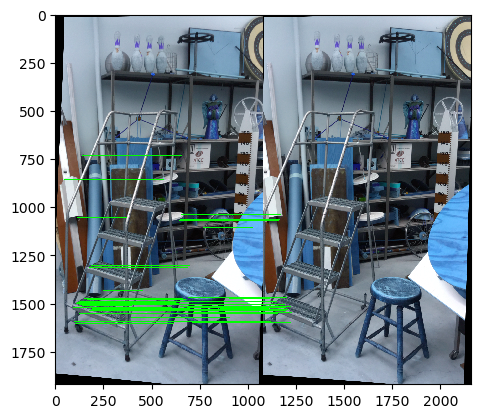

In [9]:
# Create a new image that will contain the drawn matches
height_1, width_1 = img_1.shape[:2]
height_2, width_2 = img_2.shape[:2]
# new_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
new_img=np.hstack([img_1,img_2])

# Iterate over each point pair in pts1 and pts2
for i in range(100):
    pt1 = tuple(map(int, pts1[i]))
    pt2 = tuple(map(int, pts2[i]))

    # For each pair, draw a line connecting the two points on the new image
    pt2 = (pt2[0] + width_1, pt2[1])
    cv2.line(new_img, pt1, pt2, (0, 255, 0), 1)

# Display the new image with the drawn matches
plt.imshow(new_img)
cv2.imwrite('Matches.jpg', new_img)
plt.show()


In [10]:
def compute_fundamental_matrix(src_points,dst_points):
    # Create matrix A from source and destination points
    
    A = []
    for src_point, dst_point in zip(src_points, dst_points):
        x1, y1,z1 = src_point
        x, y,z = dst_point
        A.append([x1*x, x1*y, x1, y1*x, y1*y, y1, x, y, 1])

    A = np.array(A)
    # Compute SVD of A
    U, S, V = np.linalg.svd(A)

    fundamental_matrix = V[-1,:].reshape(3, 3)
    U, S, Vt = np.linalg.svd(fundamental_matrix)

    S[2] = 0

    fundamental_matrix= U @ np.diag(S) @ Vt

    return fundamental_matrix

In [11]:
def normalize(points):
    
    centroid = np.mean(points, axis=0)
    
    centered_points = points - centroid
    
    # Scale the points so that the average distance from the origin is equal to sqrt(2).
    s = (2 / np.mean(np.sum(centered_points ** 2, axis=1))) ** 0.5
    
    # Combine the translation and scaling transformations into a single 3x3 matrix.
    T_scale = np.diag([s, s, 1])
    T_trans = np.array([[1, 0, -centroid[0]], [0, 1, -centroid[1]], [0, 0, 1]])
    T = T_scale.dot(T_trans)
    
    # Apply the transformation to the homogeneous coordinates of the points.
    homogeneous_points = np.column_stack((points, np.ones(points.shape[0])))
    normalized_points = (T.dot(homogeneous_points.T)).T
    
    return normalized_points, T

In [12]:
def estimate_fundamental_matrix(pts1, pts2, threshold=0.008, sample_size=8, max_iterations=2000):
    # Normalize input points
    pts1_norm, T1 = normalize(pts1)
    pts2_norm, T2 = normalize(pts2)

    # Initialize variables
    best_F = None
    best_n_inliers = 0
    inliers = []

    # Iterate over RANSAC samples
    for i in range(max_iterations):
        # Select a random sample of corresponding points
        sample_indices = np.random.choice(pts1.shape[0], sample_size, replace=False)
        src_pts = pts1_norm[sample_indices,:]
        dst_pts = pts2_norm[sample_indices,:]

        # Compute fundamental matrix from sample
        F = compute_fundamental_matrix(src_pts, dst_pts)

        # Compute epipolar line constraint for all points
        no_of_inliers = 0
        temp_inliers = []
        for j in range(pts1_norm.shape[0]):
            L_r = np.dot(F,pts2_norm[j])
            D_lr = np.abs((L_r[0]*pts1_norm[j][0]+L_r[1]*pts1_norm[j][1]+L_r[2])/np.sqrt((L_r[0]**2+L_r[1]**2)))

            L_l = np.dot(pts1_norm[j],F)
            D_rl = np.abs((L_l[0]*pts2_norm[j][0]+L_l[1]*pts2_norm[j][1]+L_l[2])/np.sqrt((L_l[0]**2+L_l[1]**2)))

            if(D_lr+D_rl)<=threshold:
                no_of_inliers += 1
                temp_inliers.append([pts1[j],pts2[j]])

        # Update best solution if necessary
        if no_of_inliers > best_n_inliers:
            best_n_inliers = no_of_inliers
            best_F = F
            print(best_n_inliers)
            inliers = temp_inliers
            

        # Early termination if convergence is reached
        if no_of_inliers == pts1_norm.shape[0]:
            break

    # Denormalize fundamental matrix
    F_denorm = T2.T @ best_F @ T1




    return F_denorm,inliers


In [13]:
F,inlier=estimate_fundamental_matrix(pts1,pts2)

243
334
421
563
620
990
1321
1355
1565
1567
1572
1575


In [14]:
F_final=F/F[2,2]
print("The Estimated Fundamental Matrix is=")
print(F_final)

The Estimated Fundamental Matrix is=
[[ 5.27493551e-10  7.56930777e-06 -1.20781641e-02]
 [-7.56873640e-06 -1.68359042e-07  2.05917695e-01]
 [ 1.20934695e-02 -2.06797597e-01  1.00000000e+00]]


### DRAWING EPIPOLAR LINES

In [15]:
pts1_denorm = np.zeros((len(inlier), 2))
pts2_denorm = np.zeros((len(inlier), 2))

for k in range(len(inlier)):
    pts1_denorm[k] = inlier[k][0]
    pts2_denorm[k] = inlier[k][1]

pts1_denorm=np.uint(pts1_denorm)
pts2_denorm=np.uint(pts2_denorm)


In [16]:
random_indices = np.random.choice(pts2_denorm.shape[0], size=10, replace=False)
pts1_check=pts1_denorm[random_indices]
pts2_check=pts2_denorm[random_indices]


In [17]:
n=pts1_check.shape[0]
ones = np.ones((n, 1))

# concatenate the two arrays along axis 1 to create an n*3 array
pts1_check = np.concatenate((pts1_check, ones), axis=1)
pts2_check = np.concatenate((pts2_check, ones), axis=1)

In [18]:
def drawlines(img1,img2,lines,pts1,pts2):
    
    r,c,w = img1.shape

    for r,pt1,pt2 in zip(lines,pts1,pts2):
        colorofline = (255,0,0)
        colorofpoint= (0,255,0)
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), colorofline,3)
        pc1 = np.uint(pt1)
        pc2 = np.uint(pt2)
        img1 = cv2.circle(img1,(pc1[0],pc1[1]),5,colorofpoint,-1)
        img2 = cv2.circle(img2,(pc2[0],pc2[1]),5,colorofpoint,-1)
    return img1,img2

Epipolar lines before rectification


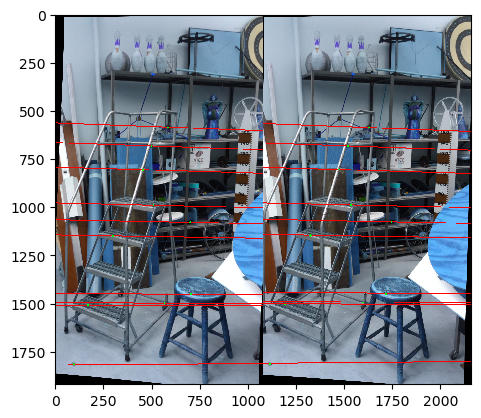

In [19]:
left_epipolar_line = []
for i in range(len(pts2_check)):
    left_epipolar_line.append(np.dot(F,pts2_check[i].T).T)
right_epipolar_line = []
for i in range(len(pts1_check)):
    right_epipolar_line.append(np.dot(pts1_check[i],F))
print("Epipolar lines before rectification")
img1, img__1_ = drawlines(img_1,img_2,left_epipolar_line,pts1_check,pts2_check)
img2, img__2_ = drawlines(img_2,img_1,right_epipolar_line,pts2_check,pts1_check)
# plt.subplot(121),plt.imshow(img1,interpolation='bicubic')
# plt.subplot(122),plt.imshow(img2,interpolation='bicubic')
# plt.show()
img = np.concatenate((img1,img2), axis =1)
plt.imshow(img)
cv2.imwrite('epi_lines_before.jpg', img)
plt.show()

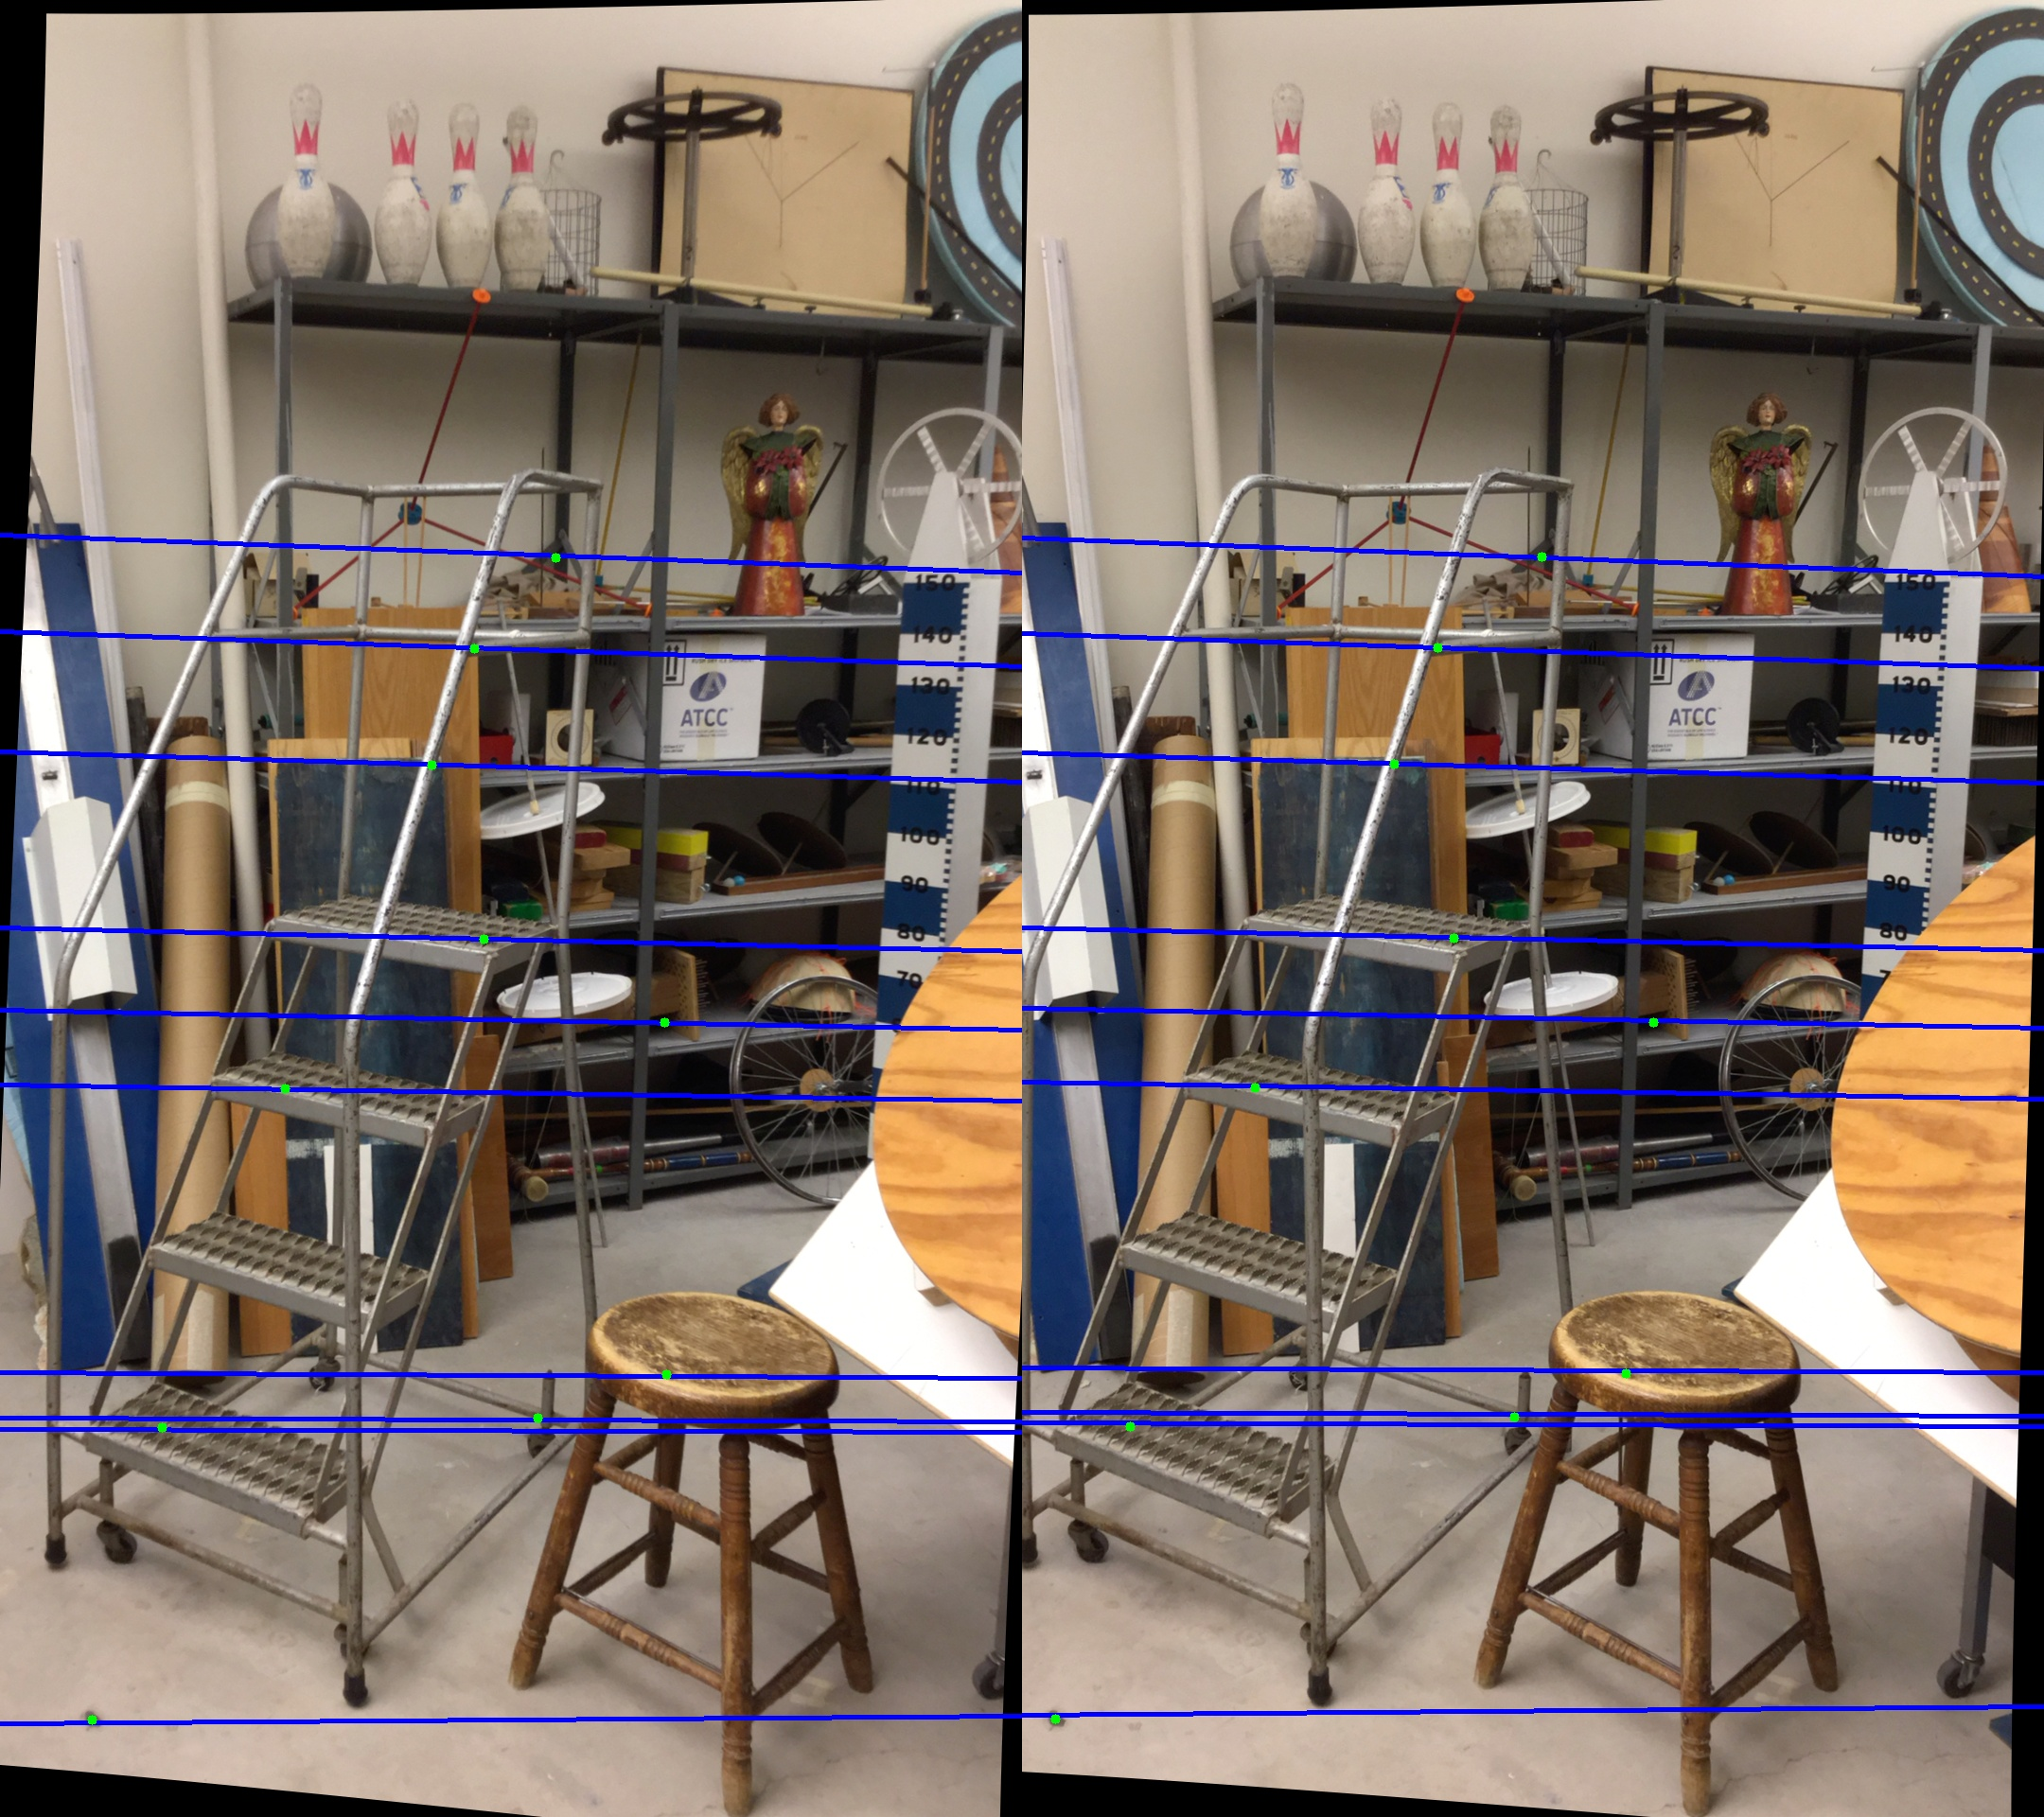

In [20]:
Image("epi_lines_before.jpg")

In [21]:
def Posible_CameraPoses(E_matrix):
    R_possible = []
    C_possible = []
    U,_,V = np.linalg.svd(E_matrix)
    
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
    
    C1 = U[:,-1]
    R1 = np.dot(U,np.dot(W,V))
    if np.linalg.det(R1) == -1:
        R1 = -R1
        C1 = -C1
    R_possible.append(R1)
    C_possible.append(C1)
        
    C2 = U[:,-1]
    R2 = np.dot(U,np.dot(W.T,V))
    if np.linalg.det(R2) == -1:
        R2 = -R2
        C2 = -C2
    R_possible.append(R2)
    C_possible.append(C2)
        
    C3 = -U[:,-1]
    R3 = np.dot(U,np.dot(W,V))
    if np.linalg.det(R3) == -1:
        R3 = -R3
        C3 = -C3
    R_possible.append(R3)
    C_possible.append(C3)
        
    C4 = -U[:,-1]
    R4 = np.dot(U,np.dot(W.T,V))
    if np.linalg.det(R4) == -1:
        R4 = -R4
        C4 = -C4
    R_possible.append(R4)
    C_possible.append(C4)
        
    return R_possible, C_possible

In [22]:
cam0 = np.array([[1734.16,0,333.49], [0,1734.16,958.05], [0, 0, 1]])
E=cam0.T@F@cam0
U,S,V = np.linalg.svd(E)
S = np.diag(S)
S[1,1] = 1
S[0,0] = 1
S[2,2] = 0
E = np.dot(np.dot(U,S),V)
R_possible, C_possible = Posible_CameraPoses(E)
print("EStimated Essential Matrix")
print(E)

EStimated Essential Matrix
[[ 1.08237945e-05  6.40415283e-02 -2.36447476e-02]
 [-6.44478954e-02 -7.11253646e-04  9.97639577e-01]
 [ 2.36784035e-02 -9.97667122e-01 -7.02000650e-04]]


In [23]:
def correct_camerapose(R_possible, C_possible, triangulated_points_set):
    correct_index = 0
    max_positive_z = 0
   
    for i in range(len(R_possible)):
        positive_depths=  0
        R = R_possible[i]
        C = C_possible[i].reshape(3,1)
        r3 = R[2].T
        points = triangulated_points_set[i]
       
        for point in points:
            point = point.reshape(3, 1)
            if r3 @ (point - C) > 0 and point[2] > 0:
                positive_depths += 1
               
        if positive_depths > max_positive_z:
            correct_index = i
            max_positive_z = positive_depths

    R, C = R_possible[correct_index], C_possible[correct_index]

    return R, C

In [24]:
def Trinagulated_Points(R_possible, C_possible, pts1_left, pts2_right, K1, K2):
    
    R1, R2 = np.identity(3), R_possible
    C1, C2 = np.zeros((3, 1)),  C_possible.reshape(3,1)
    
    
    P = K1@np.hstack((R1,-R1@C1))
    
    P_prime = K2@np.hstack((R2,-R2@C2))
    
    p1, p2, p3 = P
    p1_, p2_, p3_ = P_prime
    
    triangulated_points =[]
    
    for pt_left, pt_right in zip(pts1_left, pts2_right):
        x, y = pt_left
        x_, y_ = pt_right
        A = np.vstack((y * p3.T - p2.T, p1.T - x * p3.T, y_ * p3_.T - p2_.T, p1_.T-x_ * p3_.T ))
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        X = X / X[-1]
        triangulated_points.append(X[:3])
        


    return triangulated_points

In [25]:
K1,K2=cam0,cam0
trinagulated_points_set=[]
for i in range(len(R_possible)):
    trinagulated_points_set.append(Trinagulated_Points(R_possible[i], C_possible[i], pts1, pts2, K1, K2))


R, C = correct_camerapose(R_possible, C_possible, trinagulated_points_set)
print("Rotation for Camera=")
print(R)
print("Transaltion of Camera=")
print(C)

Rotation for Camera=
[[ 9.99999910e-01 -1.23765160e-05  4.24245703e-04]
 [ 1.20737229e-05  9.99999745e-01  7.13716263e-04]
 [-4.24254428e-04 -7.13711076e-04  9.99999655e-01]]
Transaltion of Camera=
[0.99766708 0.02369045 0.06402464]


In [26]:
height_1, width_1,_ = img_1.shape
height_2, width_2,_ = img_2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated( np.float32(pts1_denorm), np.float32(pts2_denorm), F, imgSize=(width_1, height_1))
print("Homography for left Image")
print(H1)
print("Homography for Right Image")
print(H2)

Homography for left Image
[[ 1.97631768e-03  1.41798320e-05 -9.19608663e-02]
 [-1.20027023e-04  2.01046202e-03  5.70024806e-02]
 [-7.51090446e-08 -3.46265691e-09  2.04629893e-03]]
Homography for Right Image
[[ 9.79589883e-01  2.33690930e-02 -1.14128660e+01]
 [-5.96282057e-02  9.98862024e-01  3.32916885e+01]
 [-3.72697858e-05 -8.89107889e-07  1.02097923e+00]]


In [27]:
image_left_rectified_1 = cv2.warpPerspective(img_1, H1, (width_1, height_1))
image_right_rectified_1 = cv2.warpPerspective(img_2, H2, (width_2, height_2))

Epipolar lines after rectification


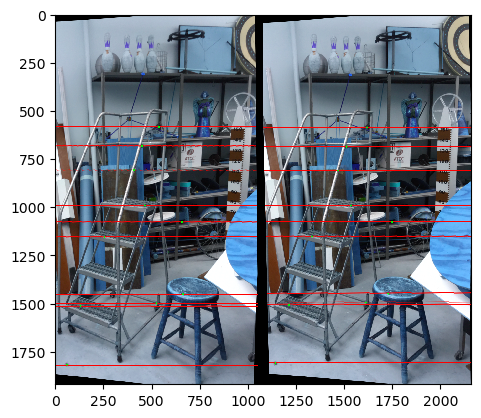

In [28]:
img = np.concatenate((image_left_rectified_1,image_right_rectified_1), axis =1)
print("Epipolar lines after rectification")
plt.imshow(img)
cv2.imwrite('perspective_epi_lines.jpg', img)
plt.show()


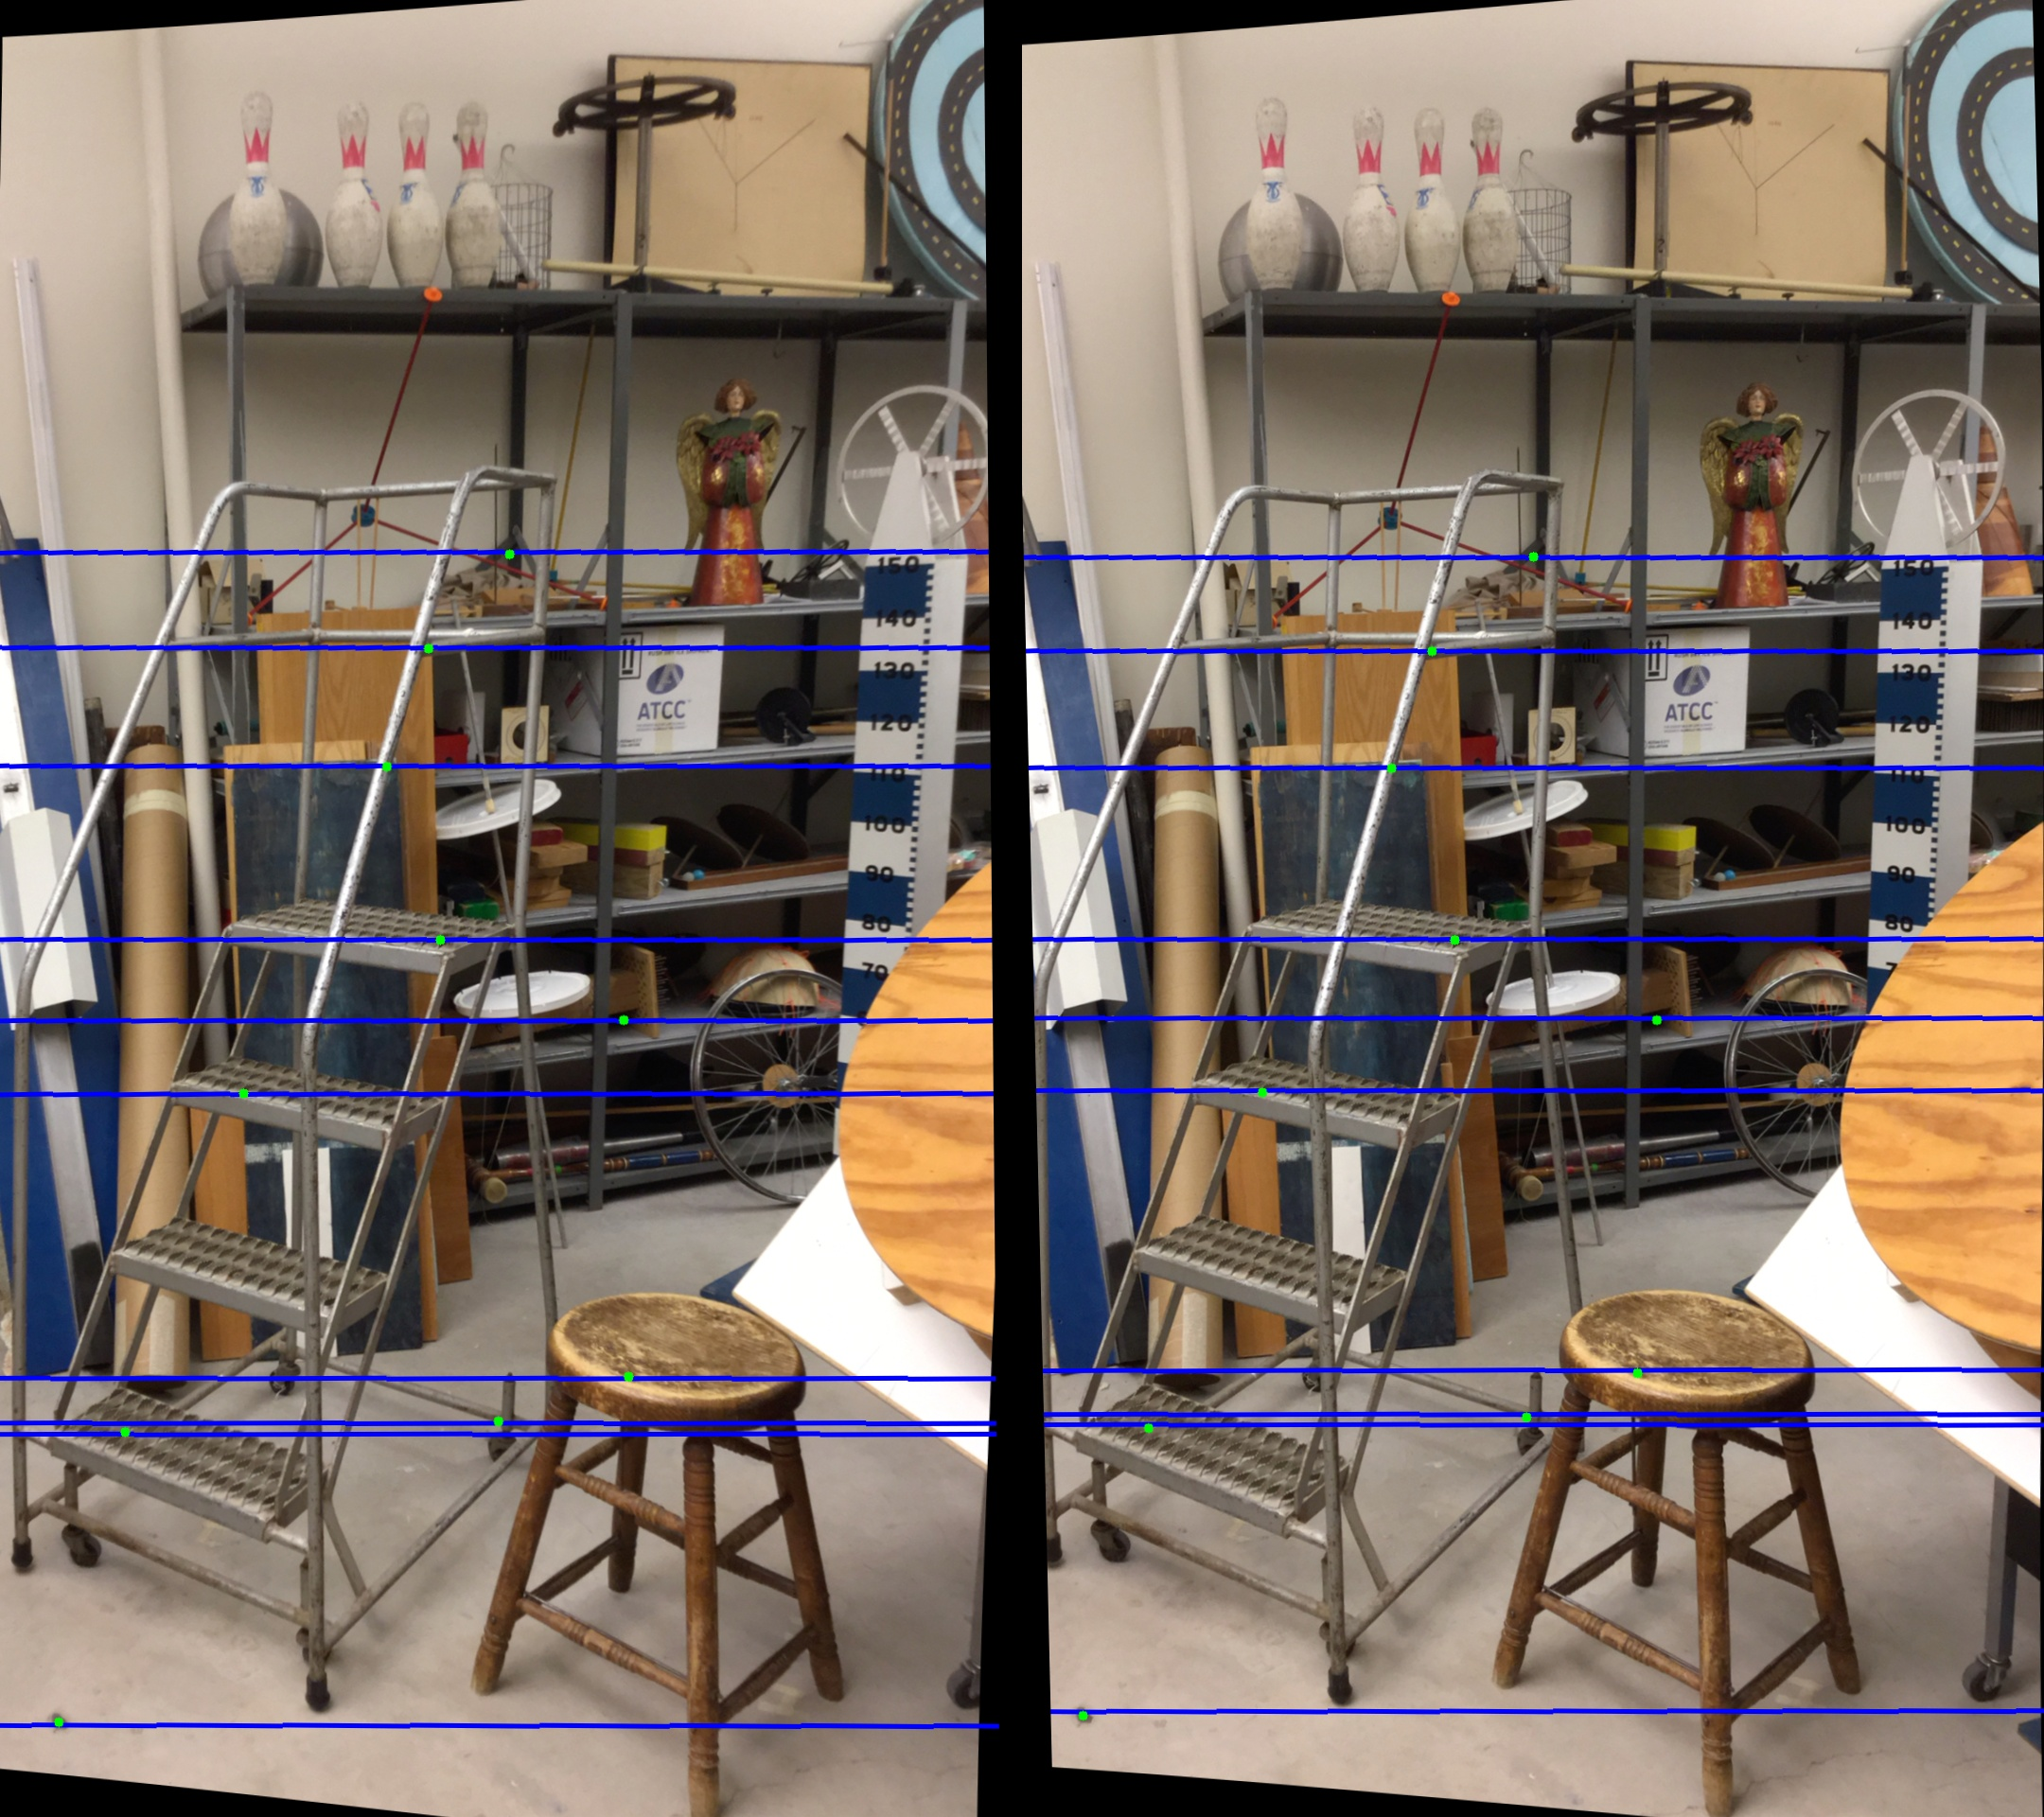

In [29]:
Image("perspective_epi_lines.jpg")

In [30]:
image_left_rectified = cv2.warpPerspective(img1_1, H1, (width_1, height_1))
image_right_rectified = cv2.warpPerspective(img1_2, H2, (width_2, height_2))

In [31]:
image_left_rect_gray = cv2.cvtColor(image_left_rectified , cv2.COLOR_BGR2GRAY)
image_right_rect_gray = cv2.cvtColor(image_right_rectified , cv2.COLOR_BGR2GRAY)

In [32]:
def Disparity_Calculation(img1, img2):

    disparity = np.zeros((img2.shape[0], img2.shape[1]), dtype=np.float64)
    
    for i in range(5,img2.shape[1]-5):
        for j in range(5, img2.shape[0]-5):
            
            E1 = img2[j-5:j+5,i-5:i+5]
            
            max_SSD = np.inf
            corrp_index = 0
            for k in range(i-100, i+100, 3):
                if (k-5) < 0 or (k+5) > img1.shape[1]-1:
                    continue
                
                E2 = img1[j-5:j+5,k-5:k+5]
                
                diff = E1 - E2
                diff = np.array(diff)
                square_element = np.square(diff)
                SSD = square_element.sum()
                if SSD < max_SSD:
                    max_SSD = SSD
                    corrp_index = k      
            disparity[j][i] = i - corrp_index
            
    disparity = disparity + np.abs(np.min(disparity)) + 1
    disparity = (disparity/np.max(disparity))*255
    disparity = disparity.astype(np.uint8)
    return disparity

In [33]:
disparity = Disparity_Calculation(image_left_rect_gray, image_right_rect_gray)
disparity_heat = cv2.applyColorMap(disparity, cv2.COLORMAP_JET)

In [34]:
cv2.imwrite('Disparity.png', disparity)
    # cv.imshow('Disparity Heatmap', disparity_heatmap)
cv2.imwrite('Disparity_Heat.png', disparity_heat)

True

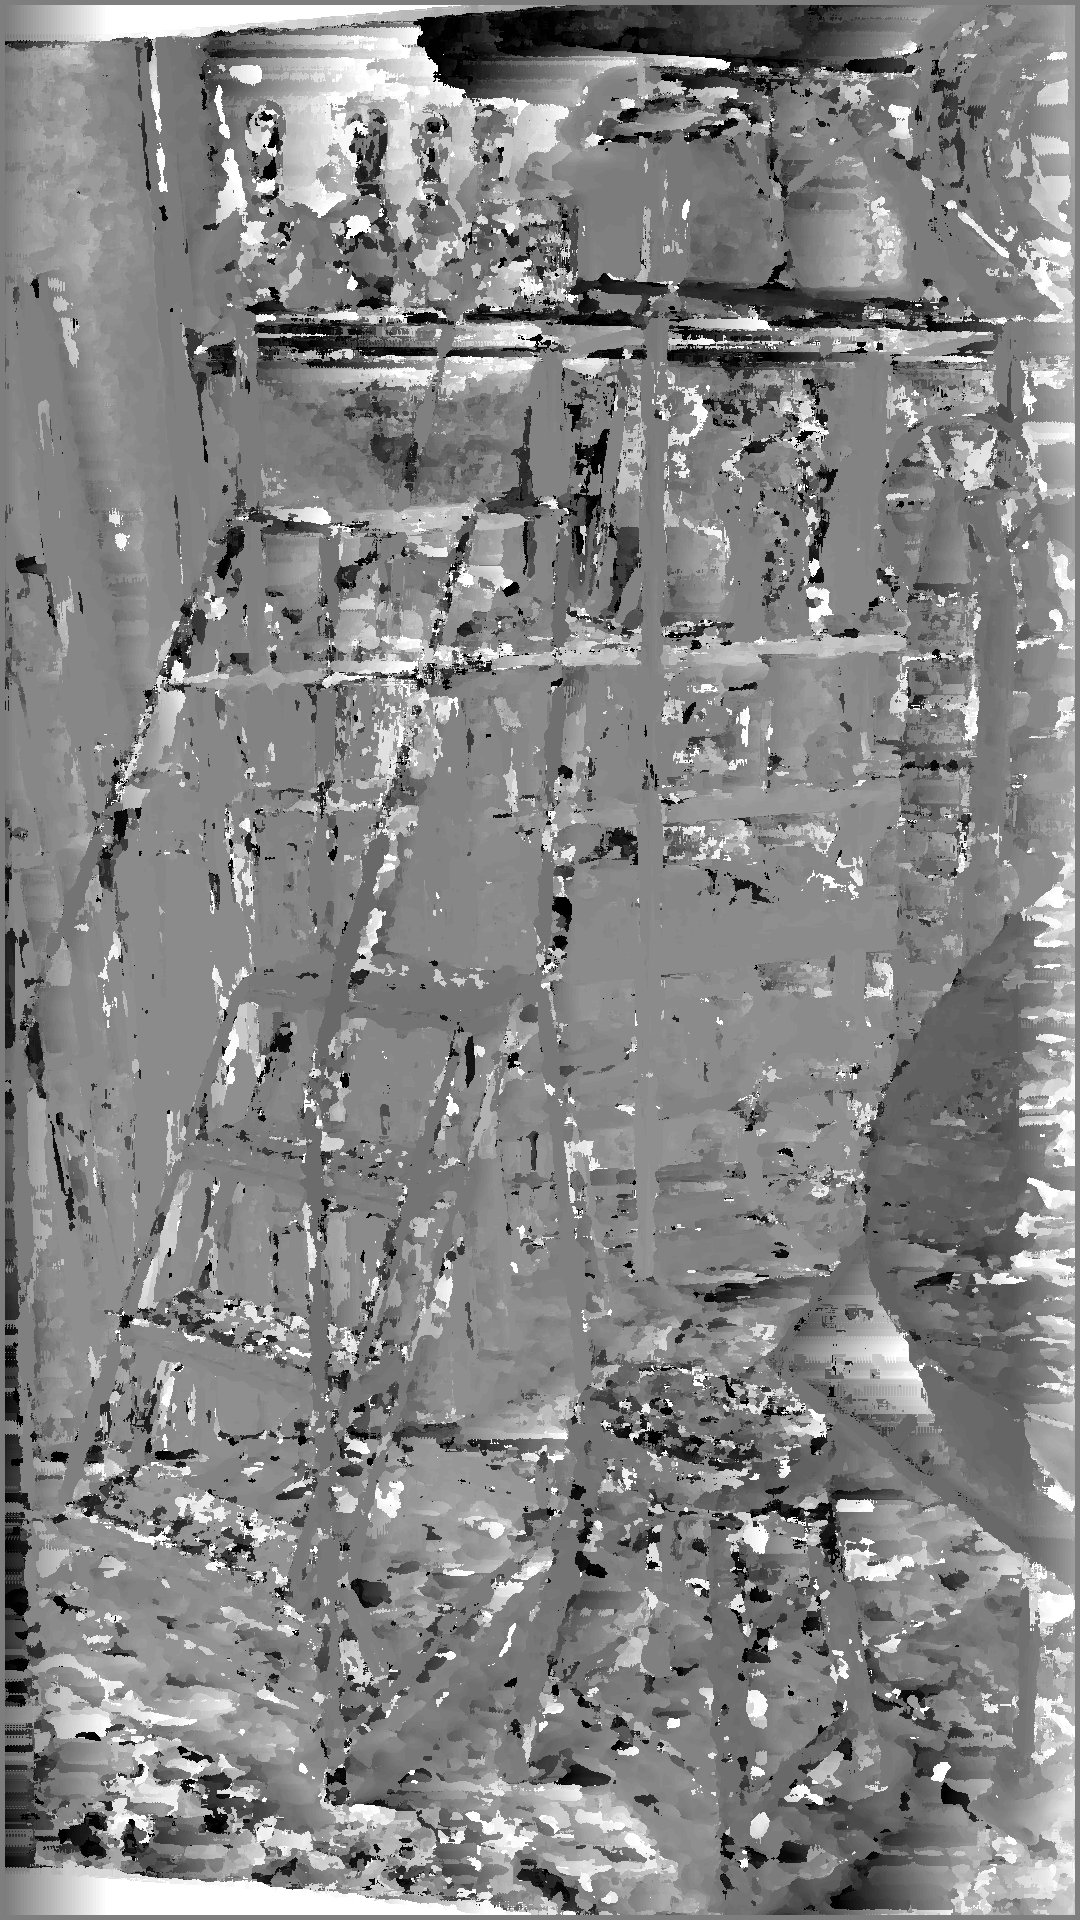

In [35]:
Image("Disparity.png")


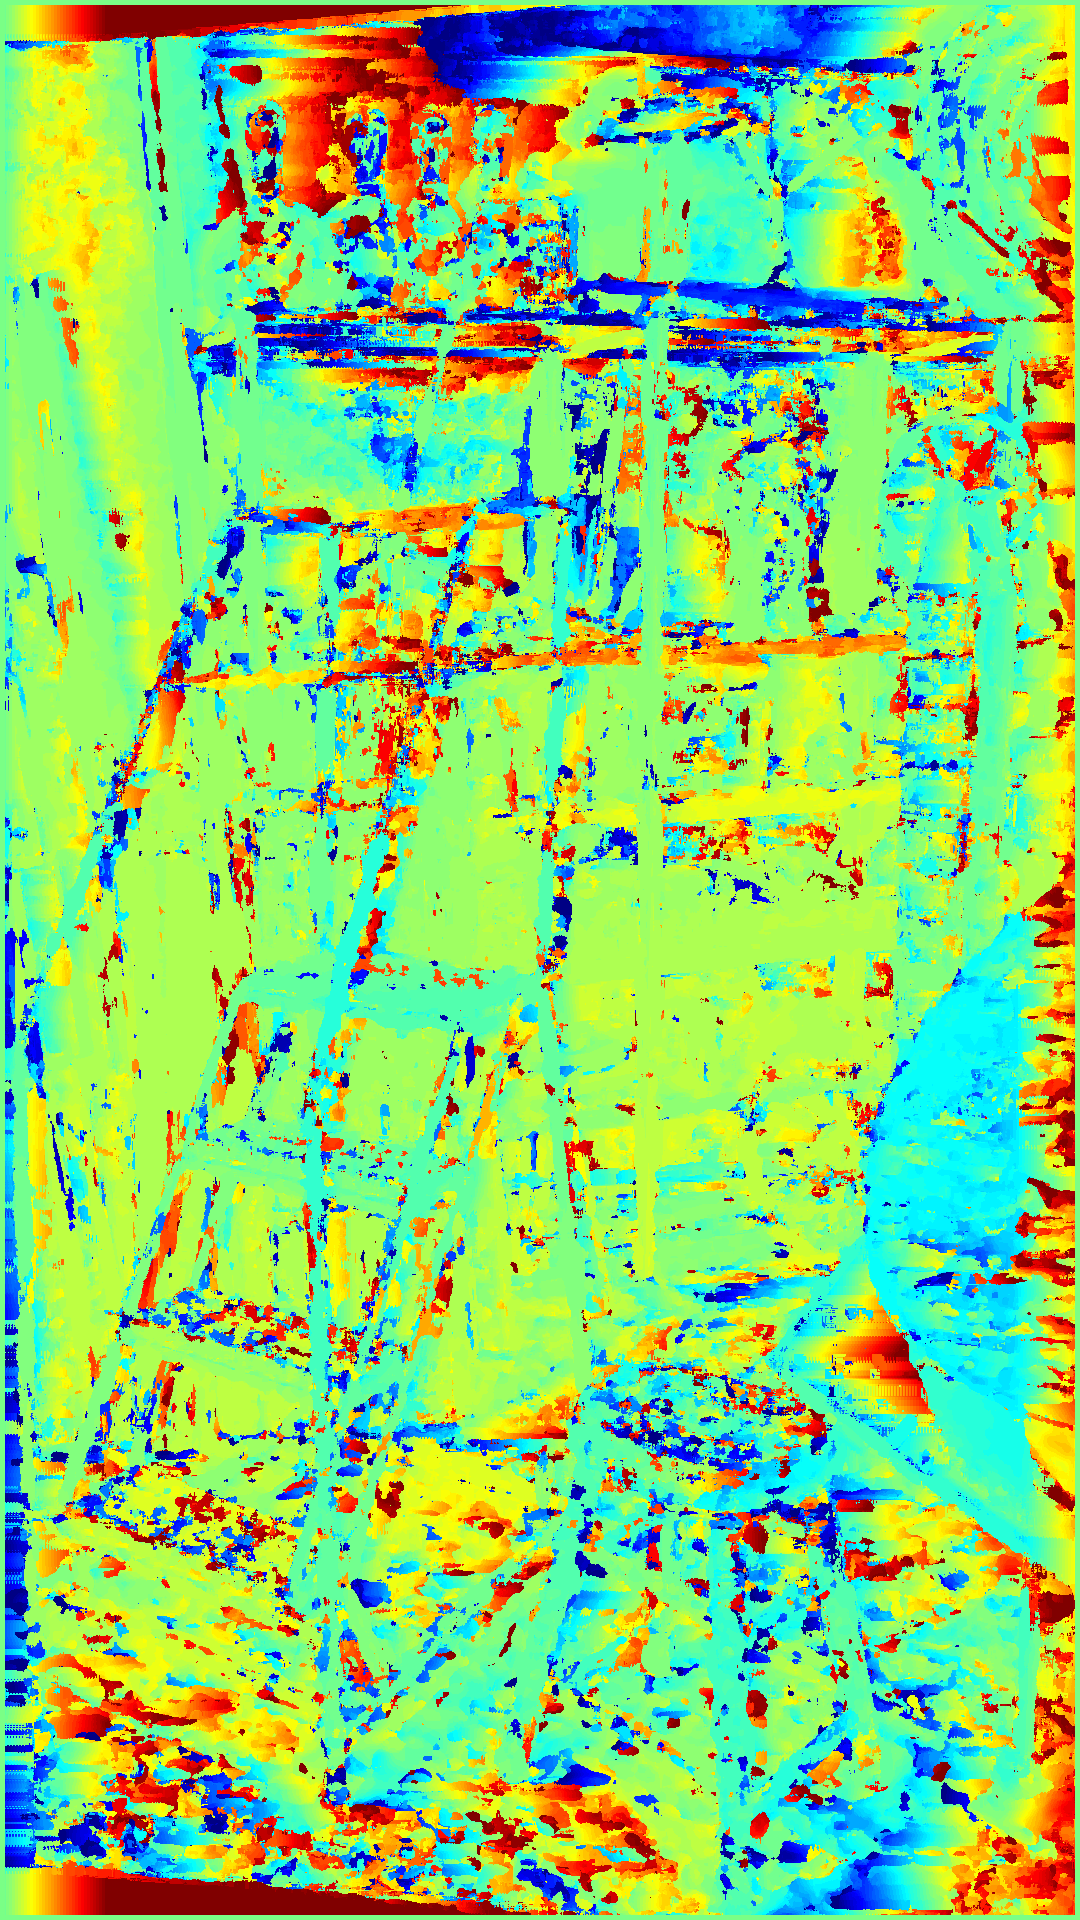

In [36]:
Image("Disparity_Heat.png")

In [37]:
def computeDepthMap(img, b, f_x):
    
    img = img.astype(np.float64)
    depth = (b * f_x)/img
    depth[depth > 5000] = 5000
    depth = (depth/np.max(depth))*255
    depth = depth.astype(np.uint8)
    
    return depth 

In [38]:
b = 228.38
f_x = 1734.16
depth = computeDepthMap(disparity,b, f_x )
depth_heat = cv2.applyColorMap(depth, cv2.COLORMAP_JET)
# cv.imshow('Depth Map', depth_map)
cv2.imwrite('Depth.png', depth)
# cv.imshow('Depth Heatmap', depth_heatmap)
cv2.imwrite('Depth_Heat.png', depth_heat)

True

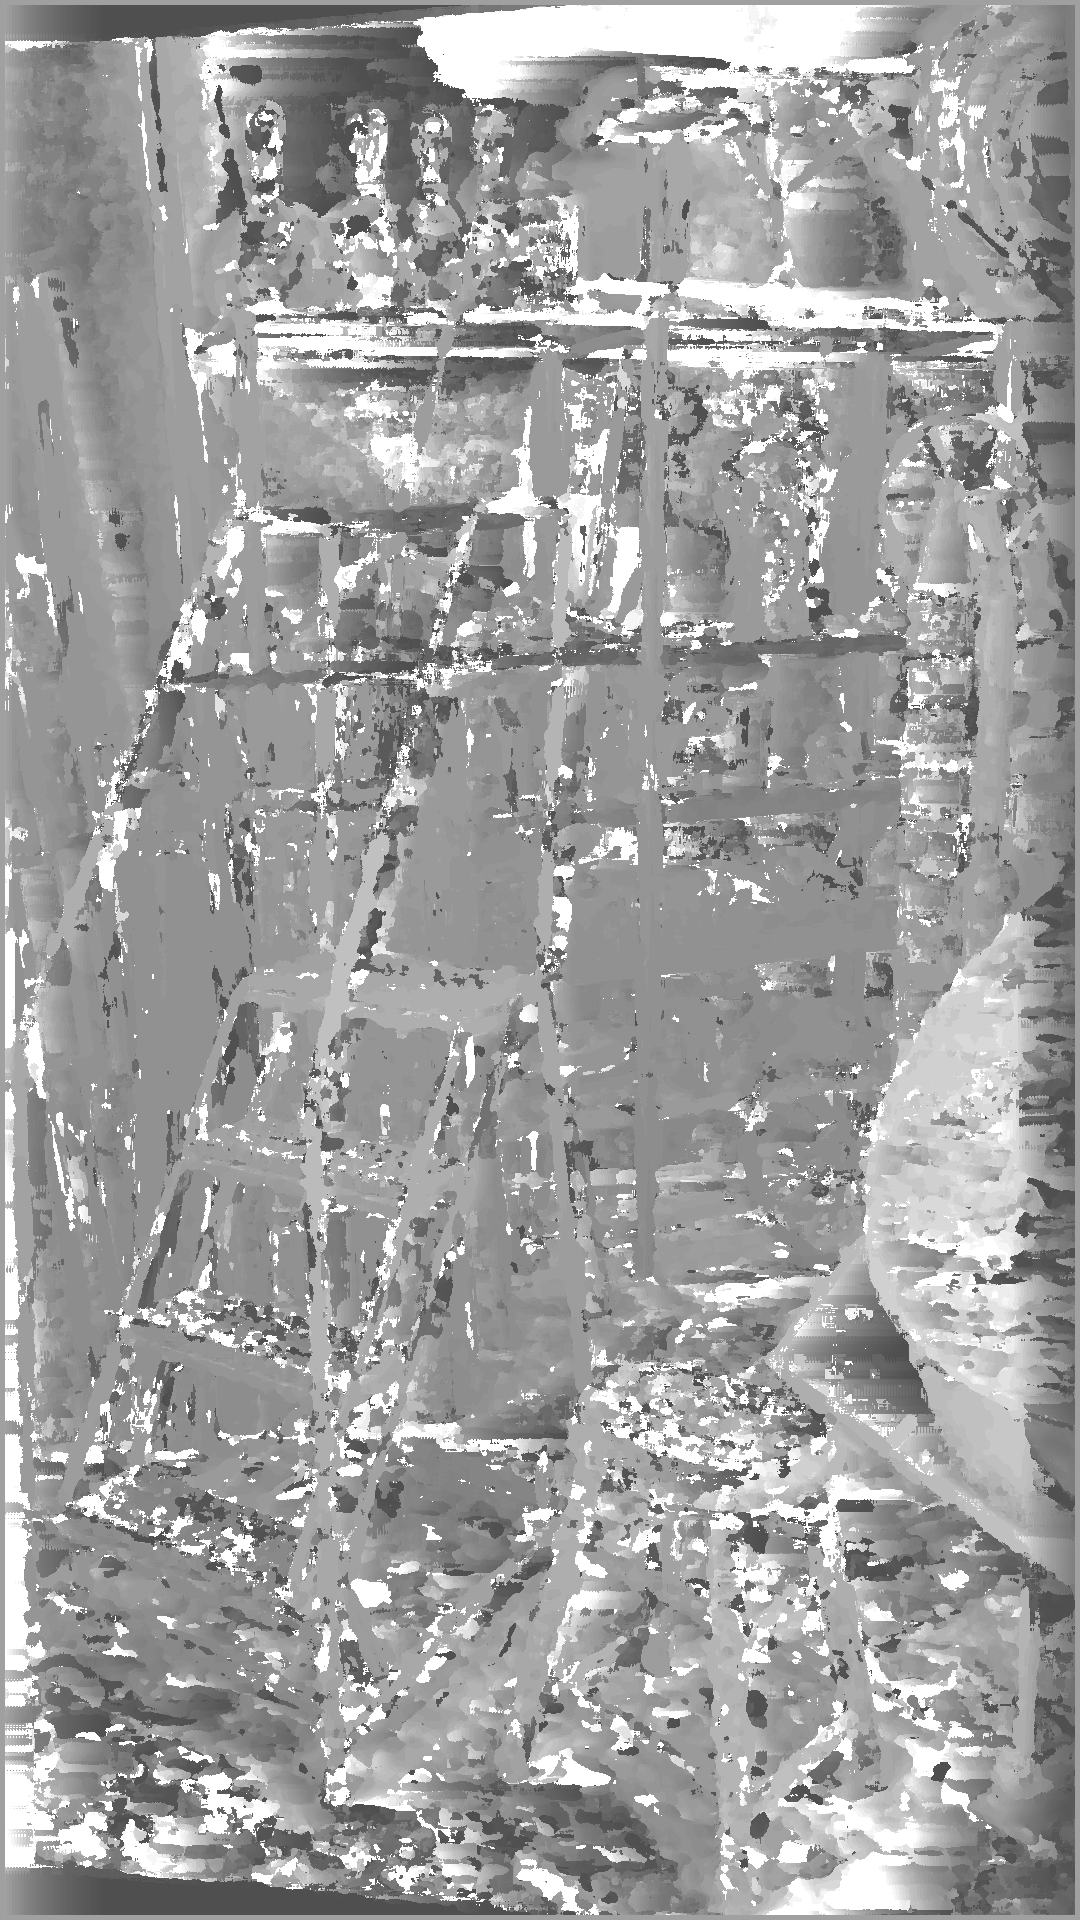

In [39]:
Image("Depth.png")


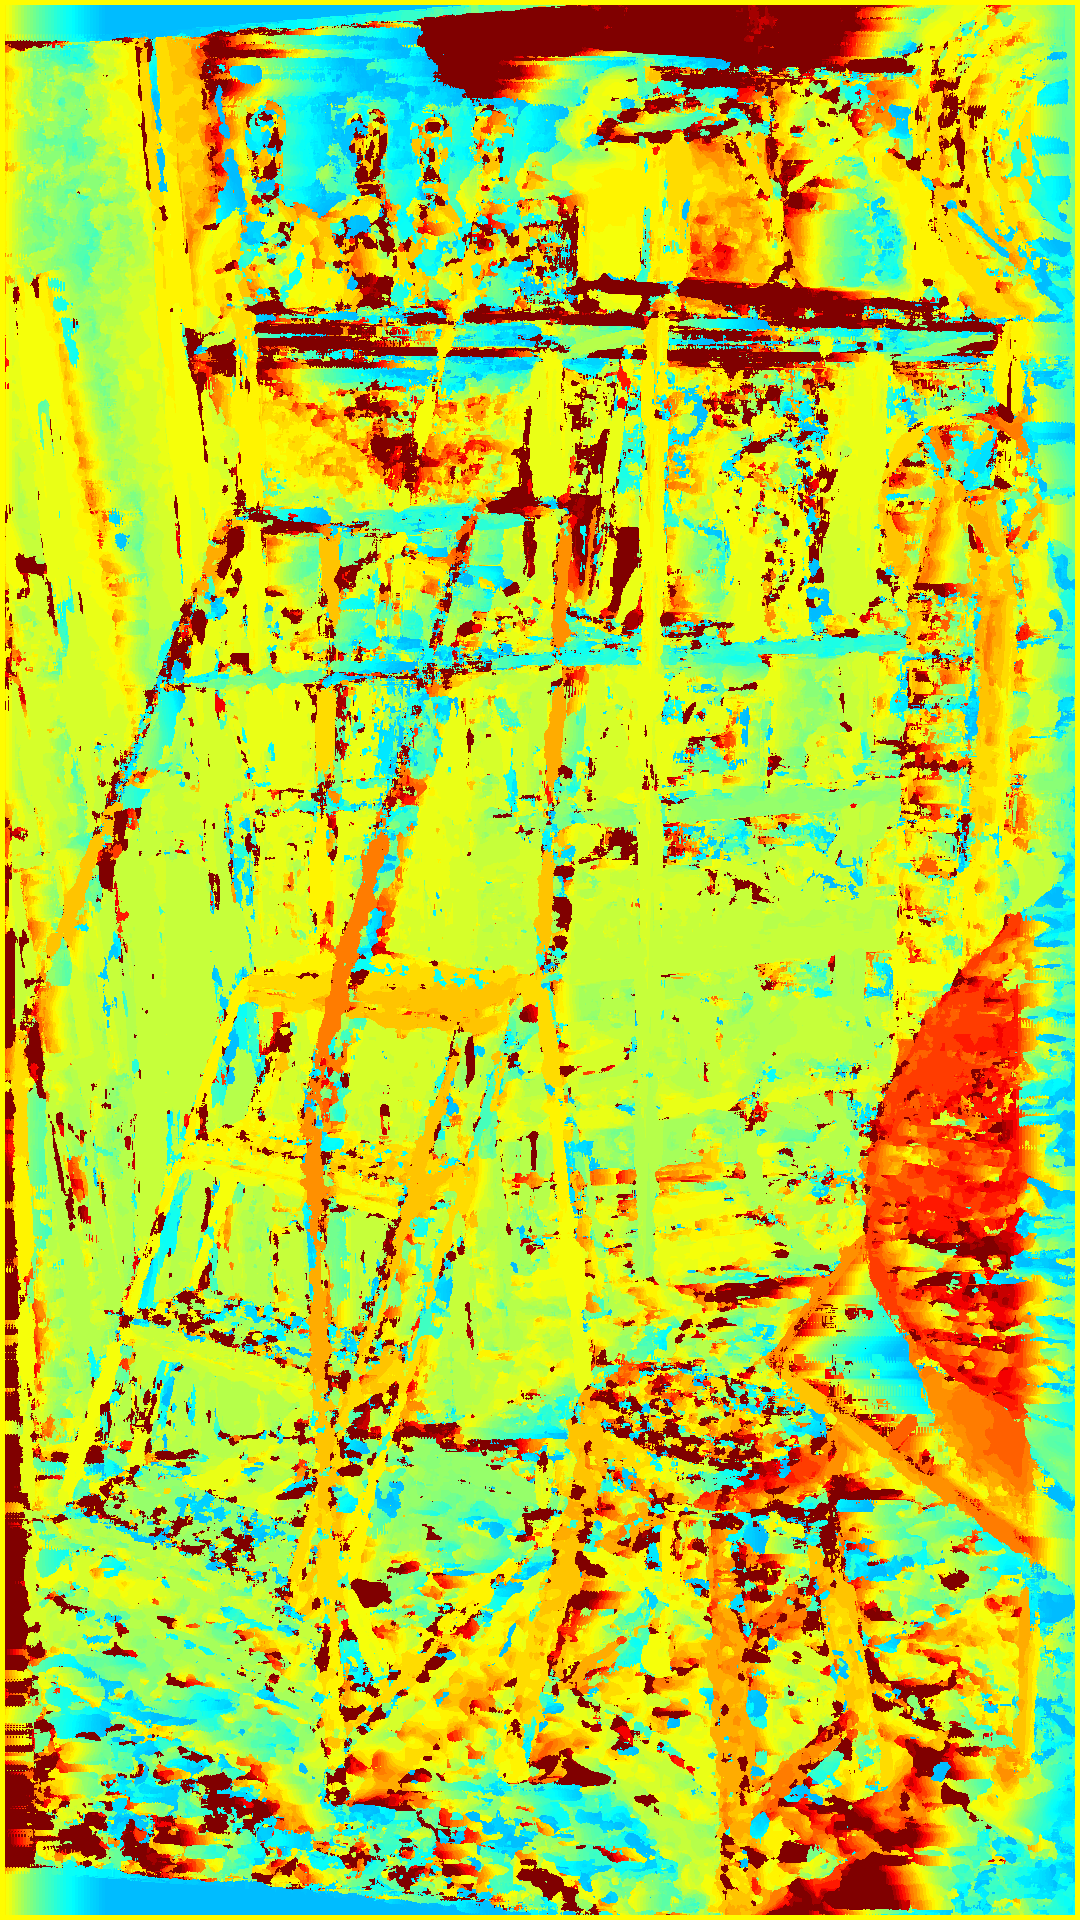

In [40]:
Image("Depth_Heat.png")

In [41]:
img1_final = np.hstack([disparity, depth])
img2_final = np.hstack([disparity_heat, depth_heat])
cv2.imwrite('final.png', img1_final)
cv2.imwrite('final_heat.png', img2_final)

True